<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Detect_Covid_19_through_X_ray_images_of_Patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1BFc2Lt2N1swO8BKRvLMEyUhLzF52RFvr',
dest_path='content/covid_image_data.zip',unzip=True)

Unzipping...Done.


# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense,Layer,AveragePooling2D,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPool2D,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
#
from tensorflow.keras.applications import VGG16
#
from tensorflow.keras.applications import VGG19
#
from tensorflow.keras.optimizers import Adam
#
from keras.applications import DenseNet201
#
from tensorflow.keras.utils import to_categorical
#
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#
from tensorflow.keras.regularizers import l1_l2
#
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score

# 

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing

In [10]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
#
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score
from PIL import Image
import cv2

In [5]:
train = pd.read_csv("/content/content/covid_image_data/Training_set_covid.csv")
train.head()

,filename,label
0,Image_1.jpg,1
1,Image_2.jpg,0
2,Image_3.jpg,0
3,Image_4.jpg,0
4,Image_5.jpg,0


In [6]:
test = pd.read_csv("/content/content/covid_image_data/Testing_set_covid.csv")
test.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [7]:
test_image_order = pd.read_csv("/content/content/covid_image_data/Testing_set_covid.csv")
test_image_order.head()

file_paths_test = [[fname, '/content/content/covid_image_data/test/' + fname] for fname in test_image_order['filename']]

test_images = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])
test_images.head()

,filename,filepaths
0,Image_1.jpg,/content/content/covid_image_data/test/Image_1...
1,Image_2.jpg,/content/content/covid_image_data/test/Image_2...
2,Image_3.jpg,/content/content/covid_image_data/test/Image_3...
3,Image_4.jpg,/content/content/covid_image_data/test/Image_4...
4,Image_5.jpg,/content/content/covid_image_data/test/Image_5...


In [8]:
image_size = 224 
test_pixel_data = []

In [12]:
for i in range(len(test_images)):

  img_array = cv2.imread(test_images['filepaths'][i], cv2.COLOR_BGR2RGB) 

  new_img_array = cv2.resize(img_array, (image_size, image_size))
  #new_img_array = cv2.GaussianBlur(new_img_array,(5,5),0)
  test_pixel_data.append(new_img_array)

In [13]:
test_pixel_data = np.array(test_pixel_data)

**Define callbacks**

In [16]:
from keras import backend as K
import tensorflow as tf

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_accuracy',
  factor=0.2,
  patience=5,
  min_lr=0.0001,
)

In [18]:
import tensorflow as tf
ACCURACY_THRESHOLD = 0.96
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True
callbacks = myCallback()

In [39]:
cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1, mode='auto')]

In [20]:
from sklearn.metrics import f1_score
import tensorflow as tf

class IntervalEvaluation(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=()):
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
      y_pred = self.model.predict(self.X_val, verbose=0)
      prediction = []
      for i in y_pred:
        if i < 0.5:
          prediction.append(0)
        else:
          prediction.append(1)

      f1score = f1_score(self.y_val,prediction)
      print("interval evaluation - epoch: {:d} - score: {:.6f}".format(epoch, f1score))
      if f1score > 0.80:
        self.model.stop_training = True

#ival = IntervalEvaluation(validation_data=(testX1,testY1))

##Image Preprocessing using openCV

In [21]:
train_image_path = "/content/content/covid_image_data"
image_list = train.filename.values.tolist()

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
COLOR = 'blue'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

**Image Preprocessing**

In [ ]:
random_index = np.random.randint(len(train))
image_path= train_image_path + "/train/" + image_list[random_index ]
image_original = cv2.imread(image_path)

#Preprocess Image
image_processed = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_processed = cv2.resize(image_processed,(128,128))
image_processed = cv2.equalizeHist(image_processed)
#image_processed = cv2.medianBlur(image_processed ,3)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
image_processed  = clahe.apply(image_processed )
image_processed  = cv2.cvtColor(image_processed,cv2.COLOR_GRAY2BGR)


cv2.imwrite(image_list[random_index ], image_processed)

True

Text(0.5, 1.0, 'Clahe image Label : Non_Covid')

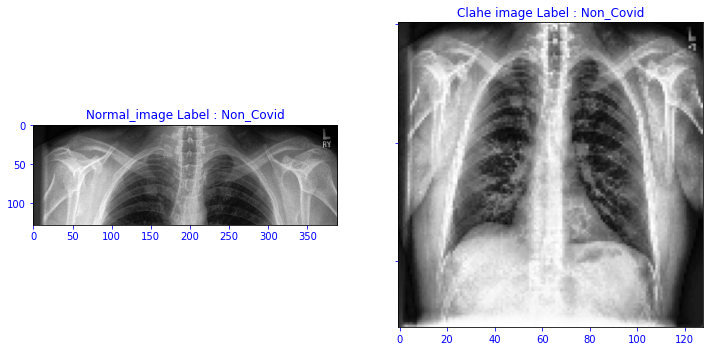

In [ ]:
label = train.iloc[random_index]['label']
ddict = {1:'COVID affected',0:'Non_Covid'}
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,10))

ax1.imshow(image_original)
ax2.imshow(image_processed)

ax1.set_title(f'Normal_image Label : {ddict[label]}')
ax2.set_title(f'Clahe image Label : {ddict[label]}')

## **Build Montages**

In [ ]:
images = []
imagepath = "/content/content/covid_image_data/train/"
for imagep in image_list[:26] :
  image = cv2.imread(imagepath+imagep)
  images.append(image)

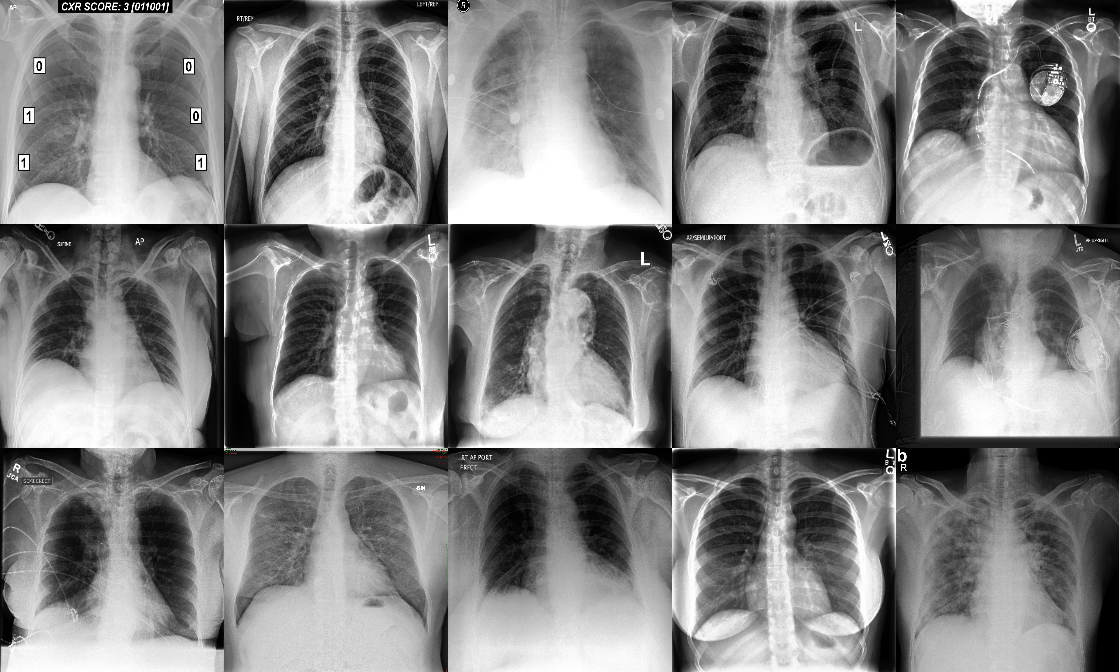

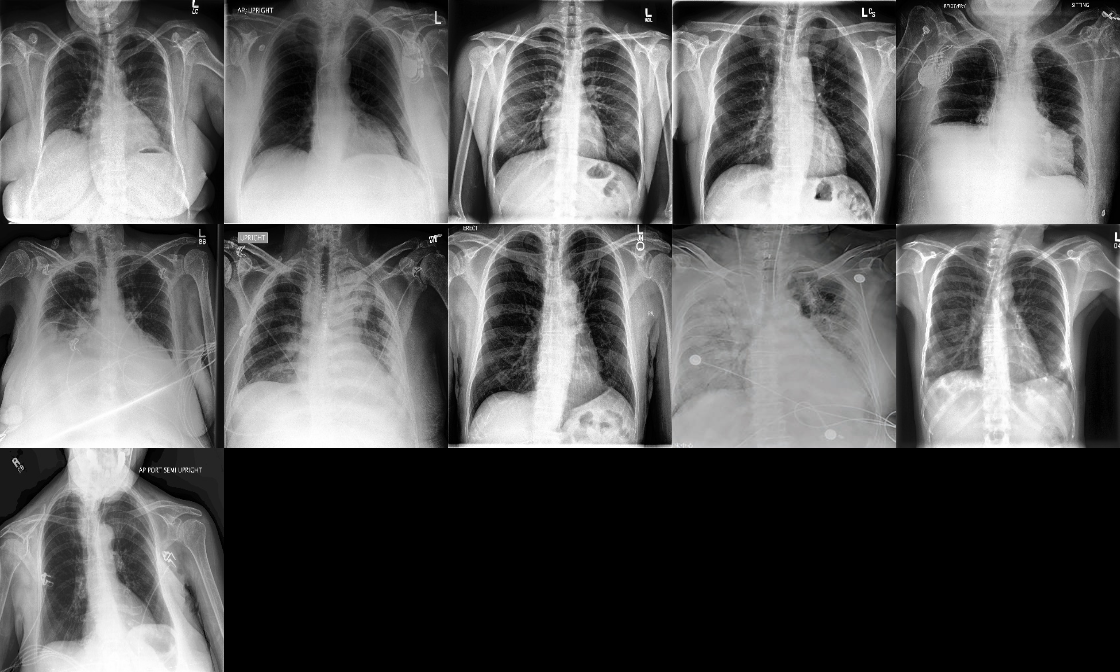

In [ ]:
from imutils import build_montages
from google.colab.patches import cv2_imshow
montages = build_montages(images,(224,224),(5,3))
for montage in montages :
  cv2_imshow(montage)

**Define Cyclic Learning rate Class**

In [23]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import *
import tempfile

In [24]:
class CyclicLR(Callback):
	"""This callback implements a cyclical learning rate policy (CLR).
	The method cycles the learning rate between two boundaries with
	some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
	The amplitude of the cycle can be scaled on a per-iteration or
	per-cycle basis.
	This class has three built-in policies, as put forth in the paper.
	"triangular":
		A basic triangular cycle w/ no amplitude scaling.
	"triangular2":
		A basic triangular cycle that scales initial amplitude by half each cycle.
	"exp_range":
		A cycle that scales initial amplitude by gamma**(cycle iterations) at each
		cycle iteration.
	For more detail, please see paper.

	# Example
		```python
			clr = CyclicLR(base_lr=0.001, max_lr=0.006,
								step_size=2000., mode='triangular')
			model.fit(X_train, Y_train, callbacks=[clr])
		```

	Class also supports custom scaling functions:
		```python
			clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
			clr = CyclicLR(base_lr=0.001, max_lr=0.006,
								step_size=2000., scale_fn=clr_fn,
								scale_mode='cycle')
			model.fit(X_train, Y_train, callbacks=[clr])
		```
	# Arguments
		base_lr: initial learning rate which is the
			lower boundary in the cycle.
		max_lr: upper boundary in the cycle. Functionally,
			it defines the cycle amplitude (max_lr - base_lr).
			The lr at any cycle is the sum of base_lr
			and some scaling of the amplitude; therefore
			max_lr may not actually be reached depending on
			scaling function.
		step_size: number of training iterations per
			half cycle. Authors suggest setting step_size
			2-8 x training iterations in epoch.
		mode: one of {triangular, triangular2, exp_range}.
			Default 'triangular'.
			Values correspond to policies detailed above.
			If scale_fn is not None, this argument is ignored.
		gamma: constant in 'exp_range' scaling function:
			gamma**(cycle iterations)
		scale_fn: Custom scaling policy defined by a single
			argument lambda function, where
			0 <= scale_fn(x) <= 1 for all x >= 0.
			mode paramater is ignored
		scale_mode: {'cycle', 'iterations'}.
			Defines whether scale_fn is evaluated on
			cycle number or cycle iterations (training
			iterations since start of cycle). Default is 'cycle'.
	"""

	def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
				 gamma=1., scale_fn=None, scale_mode='cycle'):
		super(CyclicLR, self).__init__()

		self.base_lr = base_lr
		self.max_lr = max_lr
		self.step_size = step_size
		self.mode = mode
		self.gamma = gamma
		if scale_fn == None:
			if self.mode == 'triangular':
				self.scale_fn = lambda x: 1.
				self.scale_mode = 'cycle'
			elif self.mode == 'triangular2':
				self.scale_fn = lambda x: 1 / (2. ** (x - 1))
				self.scale_mode = 'cycle'
			elif self.mode == 'exp_range':
				self.scale_fn = lambda x: gamma ** (x)
				self.scale_mode = 'iterations'
		else:
			self.scale_fn = scale_fn
			self.scale_mode = scale_mode
		self.clr_iterations = 0.
		self.trn_iterations = 0.
		self.history = {}

		self._reset()

	def _reset(self, new_base_lr=None, new_max_lr=None,
			   new_step_size=None):
		"""Resets cycle iterations.
		Optional boundary/step size adjustment.
		"""
		if new_base_lr != None:
			self.base_lr = new_base_lr
		if new_max_lr != None:
			self.max_lr = new_max_lr
		if new_step_size != None:
			self.step_size = new_step_size
		self.clr_iterations = 0.

	def clr(self):
		cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
		x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
		if self.scale_mode == 'cycle':
			return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
		else:
			return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(
				self.clr_iterations)

	def on_train_begin(self, logs={}):
		logs = logs or {}

		if self.clr_iterations == 0:
			K.set_value(self.model.optimizer.lr, self.base_lr)
		else:
			K.set_value(self.model.optimizer.lr, self.clr())

	def on_batch_end(self, epoch, logs=None):

		logs = logs or {}
		self.trn_iterations += 1
		self.clr_iterations += 1

		self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
		self.history.setdefault('iterations', []).append(self.trn_iterations)

		for k, v in logs.items():
			self.history.setdefault(k, []).append(v)

		K.set_value(self.model.optimizer.lr, self.clr())


**Define Optimum Learning rate finder**

In [25]:
class LearningRateFinder:
	def __init__(self, model, stopFactor=4, beta=0.98):
		# store the model, stop factor, and beta value (for computing
		# a smoothed, average loss)
		self.model = model
		self.stopFactor = stopFactor
		self.beta = beta

		# initialize our list of learning rates and losses,
		# respectively
		self.lrs = []
		self.losses = []

		# initialize our learning rate multiplier, average loss, best
		# loss found thus far, current batch number, and weights file
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def reset(self):
		# re-initialize all variables from our constructor
		self.lrs = []
		self.losses = []
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def is_data_iter(self, data):
		# define the set of class types we will check for
		iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
			 "DataFrameIterator", "Iterator", "Sequence"]

		# return whether our data is an iterator
		return data.__class__.__name__ in iterClasses

	def on_batch_end(self, batch, logs):
		# grab the current learning rate and add log it to the list of
		# learning rates that we've tried
		lr = K.get_value(self.model.optimizer.lr)
		self.lrs.append(lr)

		# grab the loss at the end of this batch, increment the total
		# number of batches processed, compute the average average
		# loss, smooth it, and update the losses list with the
		# smoothed value
		l = logs["loss"]
		self.batchNum += 1
		self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
		smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
		self.losses.append(smooth)

		# compute the maximum loss stopping factor value
		stopLoss = self.stopFactor * self.bestLoss

		# check to see whether the loss has grown too large
		if self.batchNum > 1 and smooth > stopLoss:
			# stop returning and return from the method
			self.model.stop_training = True
			return

		# check to see if the best loss should be updated
		if self.batchNum == 1 or smooth < self.bestLoss:
			self.bestLoss = smooth

		# increase the learning rate
		lr *= self.lrMult
		K.set_value(self.model.optimizer.lr, lr)

	def find(self, trainData, startLR, endLR, epochs=None,
		stepsPerEpoch=None, batchSize=32, sampleSize=2048,
		verbose=1):
		# reset our class-specific variables
		self.reset()

		# determine if we are using a data generator or not
		useGen = self.is_data_iter(trainData)

		# if we're using a generator and the steps per epoch is not
		# supplied, raise an error
		if useGen and stepsPerEpoch is None:
			msg = "Using generator without supplying stepsPerEpoch"
			raise Exception(msg)

		# if we're not using a generator then our entire dataset must
		# already be in memory
		elif not useGen:
			# grab the number of samples in the training data and
			# then derive the number of steps per epoch
			numSamples = len(trainData[0])
			stepsPerEpoch = np.ceil(numSamples / float(batchSize))

		# if no number of training epochs are supplied, compute the
		# training epochs based on a default sample size
		if epochs is None:
			epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

		# compute the total number of batch updates that will take
		# place while we are attempting to find a good starting
		# learning rate
		numBatchUpdates = epochs * stepsPerEpoch

		# derive the learning rate multiplier based on the ending
		# learning rate, starting learning rate, and total number of
		# batch updates
		self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

		# create a temporary file path for the model weights and
		# then save the weights (so we can reset the weights when we
		# are done)
		self.weightsFile = tempfile.mkstemp()[1]
		self.model.save_weights(self.weightsFile)

		# grab the *original* learning rate (so we can reset it
		# later), and then set the *starting* learning rate
		origLR = K.get_value(self.model.optimizer.lr)
		K.set_value(self.model.optimizer.lr, startLR)

		# construct a callback that will be called at the end of each
		# batch, enabling us to increase our learning rate as training
		# progresses
		callback = LambdaCallback(on_batch_end=lambda batch, logs:
			self.on_batch_end(batch, logs))

		# check to see if we are using a data iterator
		if useGen:
			self.model.fit_generator(
				trainData,
				steps_per_epoch=stepsPerEpoch,
				epochs=epochs,
				verbose=verbose,
				callbacks=[callback])

		# otherwise, our entire training data is already in memory
		else:
			# train our model using Keras' fit method
			self.model.fit(
				trainData[0], trainData[1],
				batch_size=batchSize,
				epochs=epochs,
				callbacks=[callback],
				verbose=verbose)

		# restore the original model weights and learning rate
		self.model.load_weights(self.weightsFile)
		K.set_value(self.model.optimizer.lr, origLR)

	def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
		# grab the learning rate and losses values to plot
		lrs = self.lrs[skipBegin:-skipEnd]
		losses = self.losses[skipBegin:-skipEnd]

		# plot the learning rate vs. loss
		plt.plot(lrs, losses)
		plt.xscale("log")
		plt.xlabel("Learning Rate (Log Scale)")
		plt.ylabel("Loss")

		# if the title is not empty, add it to the plot
		if title != "":
			plt.title(title)

**Invoke Cyclic Rates**

In [ ]:
MIN_LR = 1e-6
MAX_LR = 1e-4
BATCH_SIZE = 32
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 48

In [ ]:
trainX1.shape[0]/32

86.96875

In [ ]:
lrf = LearningRateFinder(model)
lrf.find(train_generator,
		      1e-10, 1e+1,
		    stepsPerEpoch=87,
		    epochs=30,
		    batchSize=BATCH_SIZE)

Epoch 1/30
87/87 [==============================] - 7s 78ms/step - loss: 0.0198 - accuracy: 0.9953 - f1_m: 0.9682


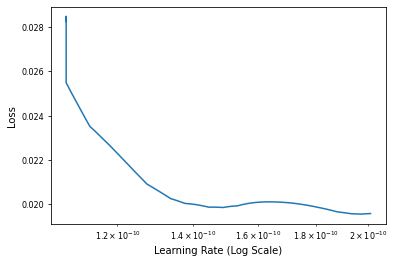

In [ ]:
lrf.plot_loss()
plt.show()

In [ ]:
1.2 * 10 **-10

1.2e-10

In [ ]:
MIN_LR = 1e-5
MAX_LR = 1e-4

In [ ]:
STEP_SIZE =8

In [ ]:
stepSize = STEP_SIZE * (trainX1.shape[0] // BATCH_SIZE)
clr = CyclicLR(mode=CLR_METHOD,base_lr=MIN_LR,max_lr=MAX_LR,step_size=stepSize)

In [ ]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=validation_generator,
	validation_steps=len(testX1) // BS,
	epochs=30,class_weight={0:1,1:2},callbacks=[clr])

Epoch 1/30
86/86 [==============================] - 8s 97ms/step - loss: 0.3851 - accuracy: 0.9306 - f1_m: 0.6411 - val_loss: 0.2969 - val_accuracy: 0.9301 - val_f1_m: 0.6335
Epoch 2/30
86/86 [==============================] - 8s 95ms/step - loss: 0.1670 - accuracy: 0.9884 - f1_m: 0.9277 - val_loss: 0.3340 - val_accuracy: 0.9301 - val_f1_m: 0.5685
Epoch 3/30
86/86 [==============================] - 8s 95ms/step - loss: 0.1647 - accuracy: 0.9920 - f1_m: 0.9505 - val_loss: 0.3269 - val_accuracy: 0.9345 - val_f1_m: 0.5943
Epoch 4/30
86/86 [==============================] - 8s 96ms/step - loss: 0.1570 - accuracy: 0.9949 - f1_m: 0.9522 - val_loss: 0.3742 - val_accuracy: 0.9330 - val_f1_m: 0.5657
Epoch 5/30
86/86 [==============================] - 8s 96ms/step - loss: 0.1471 - accuracy: 0.9953 - f1_m: 0.9551 - val_loss: 0.3662 - val_accuracy: 0.9330 - val_f1_m: 0.5848
Epoch 6/30
86/86 [==============================] - 8s 96ms/step - loss: 0.1355 - accuracy: 0.9953 - f1_m: 0.9664 - val_loss:

In [ ]:
preds = model.predict(testX1)
prediction = []
for value in preds:
  if value < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)
f1_score(testY1,prediction)

0.6666666666666666

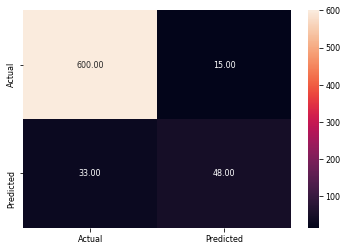

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

**Adam**

In [ ]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=validation_generator,
	validation_steps=len(testX1) // BS,
	epochs=30,class_weight={0:1,1:2})

Epoch 1/30
86/86 [==============================] - 8s 98ms/step - loss: 0.4475 - accuracy: 0.8771 - f1_m: 0.3862 - val_loss: 0.1827 - val_accuracy: 0.9122 - val_f1_m: 0.4815
Epoch 2/30
86/86 [==============================] - 8s 95ms/step - loss: 0.2718 - accuracy: 0.9175 - f1_m: 0.6196 - val_loss: 0.2218 - val_accuracy: 0.9092 - val_f1_m: 0.6884
Epoch 3/30
86/86 [==============================] - 8s 95ms/step - loss: 0.1957 - accuracy: 0.9382 - f1_m: 0.7063 - val_loss: 0.1674 - val_accuracy: 0.9301 - val_f1_m: 0.7160
Epoch 4/30
86/86 [==============================] - 8s 95ms/step - loss: 0.1566 - accuracy: 0.9531 - f1_m: 0.7951 - val_loss: 0.1298 - val_accuracy: 0.9345 - val_f1_m: 0.7391
Epoch 5/30
86/86 [==============================] - 8s 96ms/step - loss: 0.1256 - accuracy: 0.9578 - f1_m: 0.8187 - val_loss: 0.1138 - val_accuracy: 0.9464 - val_f1_m: 0.7699
Epoch 6/30
86/86 [==============================] - 8s 95ms/step - loss: 0.0949 - accuracy: 0.9727 - f1_m: 0.8465 - val_loss:

In [ ]:
testX1 = testX1/255.0
preds = model.predict(testX1)
prediction = []
for value in preds:
  if value < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)
f1_score(testY1,prediction)

0.7898089171974522

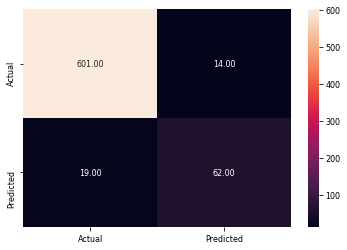

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

**RMSprop**

In [ ]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=validation_generator,
	validation_steps=len(testX1) // BS,
	epochs=30,class_weight={0:1,1:2})

Epoch 1/30
86/86 [==============================] - 9s 100ms/step - loss: 0.2151 - accuracy: 0.9393 - f1_m: 0.6872 - val_loss: 0.1256 - val_accuracy: 0.9435 - val_f1_m: 0.7312
Epoch 2/30
86/86 [==============================] - 8s 97ms/step - loss: 0.0916 - accuracy: 0.9684 - f1_m: 0.8310 - val_loss: 0.1229 - val_accuracy: 0.9524 - val_f1_m: 0.6978
Epoch 3/30
86/86 [==============================] - 8s 97ms/step - loss: 0.0561 - accuracy: 0.9851 - f1_m: 0.9269 - val_loss: 0.1334 - val_accuracy: 0.9494 - val_f1_m: 0.7836
Epoch 4/30
86/86 [==============================] - 8s 98ms/step - loss: 0.0344 - accuracy: 0.9920 - f1_m: 0.9437 - val_loss: 0.1599 - val_accuracy: 0.9464 - val_f1_m: 0.7544
Epoch 5/30
86/86 [==============================] - 8s 98ms/step - loss: 0.0356 - accuracy: 0.9902 - f1_m: 0.9376 - val_loss: 0.1488 - val_accuracy: 0.9539 - val_f1_m: 0.7733
Epoch 6/30
86/86 [==============================] - 8s 98ms/step - loss: 0.0147 - accuracy: 0.9978 - f1_m: 0.9552 - val_loss

In [ ]:
preds = model.predict(testX1)
prediction = []
for value in preds:
  if value < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)
f1_score(testY1,prediction)

0.7976878612716762

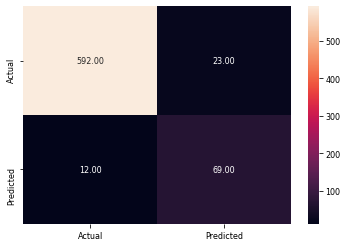

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

**RMSprop : dphi score :83.17757009345794**

## **Transfer Learning**

In [38]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16,VGG19,ResNet101,ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.layers import MaxPooling2D,MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

**Initialize lists**

In [ ]:
data = [] # has processed image
labels = []


In [ ]:
def image_preprocessing(path,img_size):
  for i in os.listdir(path):
    image_path = path + "/" + i
    #print(image_path)
    image_original = cv2.imread(image_path)
    #Preprocess Image
    image_processed = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_processed = cv2.equalizeHist(image_processed)
    #image_processed = cv2.medianBlur(image_processed ,5)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_processed  = clahe.apply(image_processed )
    image_processed  = cv2.cvtColor(image_processed,cv2.COLOR_GRAY2RGB)
    image_processed  = cv2.resize(image_processed,(img_size,img_size))
    data.append(image_processed)
    lbl = train[train['filename'] == i]['label'].tolist()[0]
    if lbl == 0:
      labels.append(0)
    else:
      labels.append(1)
  return data,labels


In [ ]:
feature,label = image_preprocessing("/content/content/covid_image_data/train",128)

In [ ]:
len(feature)

NameError: ignored

#### **Image processing without equalizer and blurring**

In [26]:
data1 = [] #has unprocessed image
label1 = []

In [27]:
def image_processing(path,img_size):
  for i in os.listdir(path):
    image_path = path + "/" +i
    #Preprocess Image
    image_processed = cv2.imread(image_path)
    image_processed  = cv2.cvtColor(image_processed,cv2.COLOR_BGR2RGB)
    image_processed  = cv2.resize(image_processed,(img_size,img_size))
    data1.append(image_processed)
    lbl = train[train['filename'] == i]['label'].tolist()[0]
    if lbl == 0:
      label1.append(0)
    else:
      label1.append(1)
  return data1,label1


In [28]:
feature1,label1 = image_processing("/content/content/covid_image_data/train",224)

## **convert the data and labels to NumPy arrays while scaling the pixel intensities to the range [0, 255]**

In [ ]:
feature= np.array(feature) / 255.0
label = np.array(label)

In [29]:
feature1 = np.array(feature1)
label1 = np.array(label1)

In [30]:
feature1.shape,label1.shape

((3479, 224, 224, 3), (3479,))

# **perform one-hot encoding on the labels when the final output layer has 2 classes to be present**

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
lb = LabelBinarizer()
label = lb.fit_transform(label)
label = to_categorical(label)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
lb = LabelBinarizer()
label1 = lb.fit_transform(label1)
label1 = to_categorical(label1)

## **partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing**

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(feature, label,test_size=0.20, stratify=label, random_state=42)

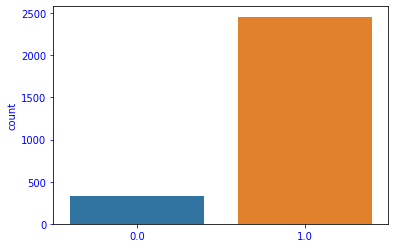

In [ ]:
import seaborn as sns
sns.countplot([y[0] for y in trainY.tolist()])

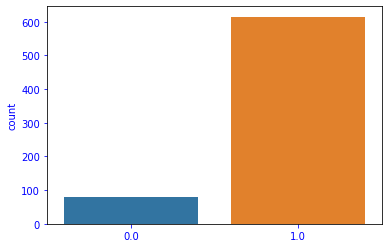

In [ ]:
sns.countplot([y[0] for y in testY.tolist()])

In [ ]:
np.unique(label1)

array([0, 1])

#### **train test split the simple processed images**

In [31]:
(trainX1, testX1, trainY1, testY1) = train_test_split(feature1, label1,test_size=0.20, stratify=label1, random_state=42)

## **initialize the training data augmentation object**

In [35]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow(trainX1,trainY1,batch_size=32)

val_generator = val_datagen.flow(testX1,testY1,batch_size=32)

test_pixel_data = test_pixel_data/255.0



**load the Densenet201 network, ensuring the head FC layer sets are left off**

In [36]:
conv_base = DenseNet201(include_top=False,input_shape=(224,224,3),weights='imagenet')

74842112/74836368 [==============================] - 0s 0us/step


In [52]:
def build_model():
    model = Sequential()
    
    model.add(DenseNet201(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet'))
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu',  kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy',f1_m])

    
    return model




In [53]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
batch_normalization_6 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_8 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_7 (Dense)              (None, 2048)             

In [55]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=val_generator,
	validation_steps=len(testX1) // BS,
	epochs=100,callbacks=cbs,class_weight={0:1,1:2})

Epoch 1/100
86/86 [==============================] - 50s 586ms/step - loss: 1426.1450 - accuracy: 0.8277 - f1_m: 0.5469 - val_loss: 1036.6686 - val_accuracy: 0.8810 - val_f1_m: 0.0000e+00
Epoch 2/100
86/86 [==============================] - 48s 563ms/step - loss: 741.2359 - accuracy: 0.9044 - f1_m: 0.6910 - val_loss: 481.9448 - val_accuracy: 0.8824 - val_f1_m: 0.0000e+00
Epoch 3/100
86/86 [==============================] - 49s 569ms/step - loss: 305.8842 - accuracy: 0.9400 - f1_m: 0.7605 - val_loss: 163.9712 - val_accuracy: 0.8824 - val_f1_m: 0.0000e+00
Epoch 4/100
86/86 [==============================] - 49s 573ms/step - loss: 87.0430 - accuracy: 0.9440 - f1_m: 0.7775 - val_loss: 33.3684 - val_accuracy: 0.8824 - val_f1_m: 0.0000e+00
Epoch 5/100
86/86 [==============================] - 50s 580ms/step - loss: 18.6829 - accuracy: 0.9353 - f1_m: 0.7633 - val_loss: 6.3402 - val_accuracy: 0.8854 - val_f1_m: 0.0000e+00
Epoch 6/100
86/86 [==============================] - 50s 579ms/step - los

Text(0, 0.5, 'Accuracy')

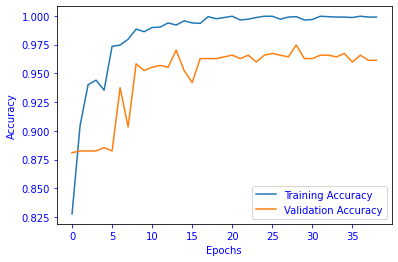

In [58]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

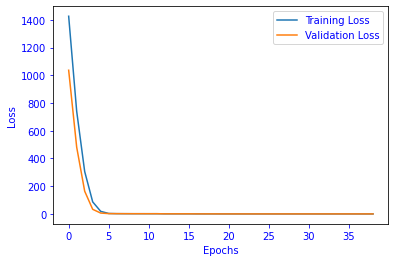

In [60]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [61]:
preds = model.predict(testX1/255.0)
prediction = []
for value in preds:
  if value <= 0.5:
    prediction.append(0)
  else:
    prediction.append(1)
f1_score(testY1,prediction)

0.8187919463087249

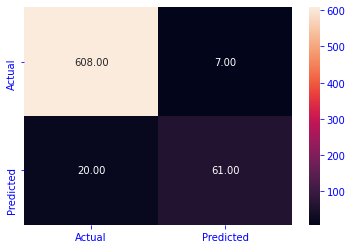

In [63]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

**Dphi Scores :88.55721393034825**

**Experiment 2**

In [71]:
cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, min_lr=1e-5, verbose=0),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=4, verbose=1, mode='auto')]

In [70]:
train_layers = [layer.name for layer in conv_base.layers[::-1][:5]]

train_layers

['relu',
 'bn',
 'conv5_block32_concat',
 'conv5_block32_2_conv',
 'conv5_block32_1_relu']

In [80]:
def build_model():
    model = Sequential()
    model.add(DenseNet201(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet'))
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy',f1_m])

    
    return model

In [81]:
model = build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
batch_normalization_12 (Batc (None, 1920)              7680      
_________________________________________________________________
dense_14 (Dense)             (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_13 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 2049      
Total params: 22,274,113
Trainable params: 22,037,121
Non-trainable params: 236,992
_________________________________________________________________


In [82]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=val_generator,
	validation_steps=len(testX1) // BS,
	epochs=100,callbacks=cbs,class_weight={0:1,1:2})

Epoch 1/100
86/86 [==============================] - 52s 607ms/step - loss: 630.9620 - accuracy: 0.7452 - f1_m: 0.4609 - val_loss: 484.7881 - val_accuracy: 0.5417 - val_f1_m: 0.3127
Epoch 2/100
86/86 [==============================] - 49s 573ms/step - loss: 366.0722 - accuracy: 0.8975 - f1_m: 0.6767 - val_loss: 258.6430 - val_accuracy: 0.2827 - val_f1_m: 0.2335
Epoch 3/100
86/86 [==============================] - 49s 573ms/step - loss: 175.9605 - accuracy: 0.9513 - f1_m: 0.8060 - val_loss: 105.3209 - val_accuracy: 0.6443 - val_f1_m: 0.3606
Epoch 4/100
86/86 [==============================] - 49s 574ms/step - loss: 58.8907 - accuracy: 0.9462 - f1_m: 0.7995 - val_loss: 25.0838 - val_accuracy: 0.6458 - val_f1_m: 0.3725
Epoch 5/100
86/86 [==============================] - 49s 574ms/step - loss: 11.0295 - accuracy: 0.9378 - f1_m: 0.7716 - val_loss: 4.4018 - val_accuracy: 0.9360 - val_f1_m: 0.7773
Epoch 6/100
86/86 [==============================] - 49s 574ms/step - loss: 3.0119 - accuracy: 

In [91]:
preds = model.predict(testX1/255.0)
prediction = []
for value in preds:
  if value < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)
f1_score(testY1,prediction)

0.8789808917197451

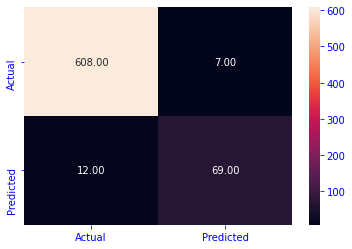

In [92]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

In [87]:
pred = model.predict(test_pixel_data)
prediction = []
for value in pred:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

#
res = pd.DataFrame({'filename': test_images['filename'], 'prediction': prediction}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res['prediction'].to_csv("submission_densenet201_layer2.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_densenet201_layer2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
res.prediction.value_counts()

0    764
1    106
Name: prediction, dtype: int64

**End Experiment 2**

In [64]:
test_pixel_data.shape

(870, 224, 224, 3)

In [65]:
pred = model.predict(test_pixel_data)
prediction = []
for value in pred:
  if value <= 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

#
res = pd.DataFrame({'filename': test_images['filename'], 'prediction': prediction}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res['prediction'].to_csv("submission_Dense_net.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_Dense_net.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
res.prediction.value_counts()

0    771
1     99
Name: prediction, dtype: int64

#### **load the VGG16 network, ensuring the head FC layer sets are left off**

In [ ]:
conv_base = VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')

#### **load the VGG19 network, ensuring the head FC layer sets are left off**

In [ ]:
conv_base = VGG19(include_top=False,input_shape=(224,224,3),weights='imagenet')

80142336/80134624 [==============================] - 1s 0us/step


**load the ResNet101 network, ensuring the head FC layer sets are left off**

In [ ]:
conv_base = ResNet101(include_top=False,input_shape=(224,224,3),weights='imagenet')

171450368/171446536 [==============================] - 2s 0us/step


#### **Resnet50**

In [ ]:
conv_base = ResNet50(include_top=False,input_shape=(224,224,3),weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
train_layers = [layer.name for layer in conv_base.layers[::-1][:5]]

train_layers

['block5_pool', 'block5_conv3', 'block5_conv2', 'block5_conv1', 'block4_pool']

In [ ]:
train_layers = [layer.name for layer in conv_base.layers[::-1][:5]]

train_layers

['block5_pool', 'block5_conv3', 'block5_conv2', 'block5_conv1', 'block4_pool']

#### **construct the head of the model that will be placed on top of the the base model**

In [ ]:
model = Sequential()

model.add(conv_base)

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

#conv_base.trainable = False
"""
for layer in conv_base.layers:
  if layer.name in train_layers:
    layer.trainable = True
  else:
    layer.trainable = False
"""

#model.compile(optimizer=RMSprop(learning_rate=1e-5,decay=1e-5/30),
model.compile(optimizer=Adam(learning_rate=1e-5,decay=1e-5/30),
#model.compile(optimizer=Adam(learning_rate=0.0001),
loss='binary_crossentropy',
metrics=['accuracy',f1_m])

In [ ]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 513       
Total params: 27,560,769
Trainable params: 19,925,505
Non-trainable params: 7,635,264
_________________________________________________________________


#### **place the head FC model on top of the base model (this will becomethe actual model we will train)**

**VGG16**

In [ ]:
1*10**-5

1e-05

**learning rate = 0.0001**

In [ ]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=validation_generator,
	validation_steps=len(testX1) // BS,
	epochs=30,class_weight={0:1,1:2})

Epoch 1/30
86/86 [==============================] - 8s 96ms/step - loss: 0.2213 - accuracy: 0.9775 - f1_m: 0.8648 - val_loss: 0.4501 - val_accuracy: 0.9345 - val_f1_m: 0.6334
Epoch 2/30
86/86 [==============================] - 8s 94ms/step - loss: 0.1607 - accuracy: 0.9931 - f1_m: 0.9555 - val_loss: 0.5135 - val_accuracy: 0.9315 - val_f1_m: 0.6327
Epoch 3/30
86/86 [==============================] - 8s 96ms/step - loss: 0.1548 - accuracy: 0.9956 - f1_m: 0.9589 - val_loss: 0.5463 - val_accuracy: 0.9315 - val_f1_m: 0.6060
Epoch 4/30
86/86 [==============================] - 8s 95ms/step - loss: 0.1466 - accuracy: 0.9949 - f1_m: 0.9656 - val_loss: 0.5901 - val_accuracy: 0.9256 - val_f1_m: 0.5744
Epoch 5/30
86/86 [==============================] - 8s 95ms/step - loss: 0.1341 - accuracy: 0.9953 - f1_m: 0.9571 - val_loss: 0.6099 - val_accuracy: 0.9301 - val_f1_m: 0.6167
Epoch 6/30
86/86 [==============================] - 8s 96ms/step - loss: 0.1227 - accuracy: 0.9953 - f1_m: 0.9722 - val_loss:

**learning rate = 0.001**

In [ ]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=validation_generator,
	validation_steps=len(testX1) // BS,
	epochs=30,class_weight={0:1,1:2})

Epoch 1/30
86/86 [==============================] - 8s 97ms/step - loss: 0.1582 - accuracy: 0.9720 - f1_m: 0.8856 - val_loss: 0.8810 - val_accuracy: 0.9330 - val_f1_m: 0.6637
Epoch 2/30
86/86 [==============================] - 8s 95ms/step - loss: 0.0656 - accuracy: 0.9876 - f1_m: 0.9356 - val_loss: 1.1460 - val_accuracy: 0.9315 - val_f1_m: 0.6243
Epoch 3/30
86/86 [==============================] - 8s 95ms/step - loss: 0.0831 - accuracy: 0.9826 - f1_m: 0.8944 - val_loss: 0.8380 - val_accuracy: 0.9196 - val_f1_m: 0.7068
Epoch 4/30
86/86 [==============================] - 8s 95ms/step - loss: 0.1072 - accuracy: 0.9684 - f1_m: 0.8575 - val_loss: 2.2255 - val_accuracy: 0.9301 - val_f1_m: 0.6610
Epoch 5/30
86/86 [==============================] - 8s 94ms/step - loss: 0.2201 - accuracy: 0.9291 - f1_m: 0.7393 - val_loss: 0.9400 - val_accuracy: 0.9152 - val_f1_m: 0.6405
Epoch 6/30
86/86 [==============================] - 8s 95ms/step - loss: 0.1041 - accuracy: 0.9735 - f1_m: 0.8469 - val_loss:

In [ ]:
preds = model.predict(testX1)
prediction = []
for value in preds:
  if value < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)
f1_score(testY1,prediction)

0.6482758620689656

**learning rate == 1e-5**

In [ ]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=validation_generator,
	validation_steps=len(testX1) // BS,
	epochs=30,class_weight={0:1,1:2})

Epoch 1/30
86/86 [==============================] - 8s 97ms/step - loss: 0.2932 - accuracy: 0.9128 - f1_m: 0.5885 - val_loss: 0.1334 - val_accuracy: 0.9330 - val_f1_m: 0.6704
Epoch 2/30
86/86 [==============================] - 8s 95ms/step - loss: 0.1196 - accuracy: 0.9618 - f1_m: 0.8183 - val_loss: 0.1098 - val_accuracy: 0.9449 - val_f1_m: 0.7153
Epoch 3/30
86/86 [==============================] - 8s 96ms/step - loss: 0.0769 - accuracy: 0.9771 - f1_m: 0.8734 - val_loss: 0.1223 - val_accuracy: 0.9464 - val_f1_m: 0.7027
Epoch 4/30
86/86 [==============================] - 8s 97ms/step - loss: 0.0371 - accuracy: 0.9924 - f1_m: 0.9480 - val_loss: 0.1224 - val_accuracy: 0.9479 - val_f1_m: 0.7008
Epoch 5/30
86/86 [==============================] - 8s 96ms/step - loss: 0.0233 - accuracy: 0.9971 - f1_m: 0.9558 - val_loss: 0.1253 - val_accuracy: 0.9449 - val_f1_m: 0.7539
Epoch 6/30
86/86 [==============================] - 8s 97ms/step - loss: 0.0152 - accuracy: 0.9989 - f1_m: 0.9925 - val_loss:

In [ ]:
pred = model.predict(testX1)
prediction = []
for value in pred:
  if value < 0.5:
    prediction.append(0)
  else:
    prediction.append(1)
f1_score(testY1,prediction)



0.802547770700637

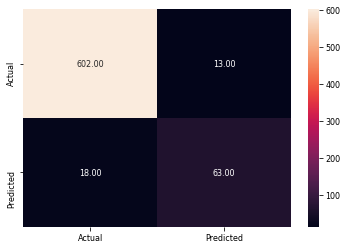

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

In [ ]:
test_pixel_data = [] # initialize an empty numpy array
image_size = 224 # image size taken is 100 here. one can take other size too
for i in range(len(test_images)):
  image_processed= cv2.imread(test_images['filepaths'][i]) # converting the image to gray scale
  image_processed  = cv2.cvtColor(image_processed,cv2.COLOR_BGR2RGB)
  new_img_array = cv2.resize(image_processed, (image_size, image_size)) # resizing the image array

  test_pixel_data.append(new_img_array)

#
test_pixel_data = np.array(test_pixel_data)
test_pixel_data  = test_pixel_data/255.0
print(test_pixel_data.shape)
#
print(test_pixel_data.shape)
pred = model.predict(test_pixel_data)
prediction = []
for value in pred:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

#
res = pd.DataFrame({'filename': test_images['filename'], 'prediction': prediction}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res['prediction'].to_csv("submission_keras_decay.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_keras_decay.csv')

(870, 224, 224, 3)
(870, 224, 224, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Dphi with rmsprop white decay :79.61165048543688**

**Dphi with Adam white decay :80.7881773399015**

**learning rate == 1e-6**

In [ ]:
history = model.fit(train_generator,steps_per_epoch=87,epochs=30,validation_data=validation_generator,validation_steps=22,class_weight={0:1,1:2})

Epoch 1/30
87/87 [==============================] - 9s 104ms/step - loss: 0.8300 - accuracy: 0.6773 - f1_m: 0.0424 - val_loss: 0.3495 - val_accuracy: 0.8003 - val_f1_m: 0.1092
Epoch 2/30
87/87 [==============================] - 8s 95ms/step - loss: 0.5840 - accuracy: 0.7416 - f1_m: 0.0496 - val_loss: 0.2495 - val_accuracy: 0.8491 - val_f1_m: 0.1051
Epoch 3/30
87/87 [==============================] - 8s 96ms/step - loss: 0.4403 - accuracy: 0.7955 - f1_m: 0.0622 - val_loss: 0.2086 - val_accuracy: 0.8707 - val_f1_m: 0.1024
Epoch 4/30
87/87 [==============================] - 8s 95ms/step - loss: 0.3743 - accuracy: 0.8132 - f1_m: 0.0538 - val_loss: 0.1882 - val_accuracy: 0.8779 - val_f1_m: 0.0985
Epoch 5/30
87/87 [==============================] - 8s 95ms/step - loss: 0.3271 - accuracy: 0.8336 - f1_m: 0.0647 - val_loss: 0.1791 - val_accuracy: 0.8793 - val_f1_m: 0.0871
Epoch 6/30
87/87 [==============================] - 8s 95ms/step - loss: 0.2926 - accuracy: 0.8426 - f1_m: 0.0358 - val_loss

f1 score 0.61

**learning rate 2.5e-5**

In [ ]:
history = model.fit(train_generator,steps_per_epoch=87,epochs=30,validation_data=validation_generator,validation_steps=22,class_weight={0:1,1:2})

Epoch 1/30
87/87 [==============================] - 8s 96ms/step - loss: 1.6485 - accuracy: 0.6770 - f1_m: 0.0000e+00 - val_loss: 0.1871 - val_accuracy: 0.8822 - val_f1_m: 0.0000e+00
Epoch 2/30
87/87 [==============================] - 8s 95ms/step - loss: 0.2124 - accuracy: 0.8915 - f1_m: 0.1748 - val_loss: 0.1902 - val_accuracy: 0.9310 - val_f1_m: 0.6017
Epoch 3/30
87/87 [==============================] - 8s 94ms/step - loss: 0.1918 - accuracy: 0.9863 - f1_m: 0.9138 - val_loss: 0.1968 - val_accuracy: 0.9325 - val_f1_m: 0.6219
Epoch 4/30
87/87 [==============================] - 8s 96ms/step - loss: 0.1835 - accuracy: 0.9899 - f1_m: 0.9243 - val_loss: 0.2049 - val_accuracy: 0.9282 - val_f1_m: 0.5846
Epoch 5/30
87/87 [==============================] - 8s 94ms/step - loss: 0.1803 - accuracy: 0.9838 - f1_m: 0.9104 - val_loss: 0.2156 - val_accuracy: 0.9339 - val_f1_m: 0.5899
Epoch 6/30
87/87 [==============================] - 8s 95ms/step - loss: 0.1771 - accuracy: 0.9831 - f1_m: 0.8980 - v

f1 score 0.6399999999999999

**learning rate 3e-6**

In [ ]:
history = model.fit(train_generator,steps_per_epoch=87,epochs=30,validation_data=validation_generator,validation_steps=22,class_weight={0:1,1:2})

Epoch 1/30
87/87 [==============================] - 8s 97ms/step - loss: 0.3400 - accuracy: 0.8735 - f1_m: 0.3746 - val_loss: 0.1846 - val_accuracy: 0.9267 - val_f1_m: 0.6391
Epoch 2/30
87/87 [==============================] - 8s 95ms/step - loss: 0.1997 - accuracy: 0.9508 - f1_m: 0.7306 - val_loss: 0.1840 - val_accuracy: 0.9267 - val_f1_m: 0.6224
Epoch 3/30
87/87 [==============================] - 8s 95ms/step - loss: 0.1517 - accuracy: 0.9792 - f1_m: 0.8913 - val_loss: 0.1860 - val_accuracy: 0.9253 - val_f1_m: 0.6192
Epoch 4/30
87/87 [==============================] - 8s 95ms/step - loss: 0.1253 - accuracy: 0.9842 - f1_m: 0.8866 - val_loss: 0.1890 - val_accuracy: 0.9224 - val_f1_m: 0.5574
Epoch 5/30
87/87 [==============================] - 8s 95ms/step - loss: 0.1030 - accuracy: 0.9856 - f1_m: 0.9312 - val_loss: 0.1935 - val_accuracy: 0.9253 - val_f1_m: 0.6750
Epoch 6/30
87/87 [==============================] - 8s 95ms/step - loss: 0.0803 - accuracy: 0.9903 - f1_m: 0.9577 - val_loss:

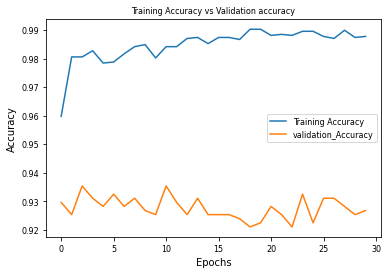

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.plot(model.history.history['accuracy'],label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],label='validation_Accuracy')
plt.title('Training Accuracy vs Validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from sklearn.metrics import f1_score,accuracy_score
f1_score(testY1,prediction)

0.6106870229007633

**VGG19**

In [ ]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=validation_generator,
	validation_steps=len(testX1) // BS,
	epochs=25,class_weight={0:1,1:2})

Epoch 1/25
86/86 [==============================] - 19s 219ms/step - loss: 0.2611 - accuracy: 0.9182 - f1_m: 0.5953 - val_loss: 0.1374 - val_accuracy: 0.9301 - val_f1_m: 0.6953
Epoch 2/25
86/86 [==============================] - 19s 223ms/step - loss: 0.1621 - accuracy: 0.9444 - f1_m: 0.7322 - val_loss: 0.1410 - val_accuracy: 0.9449 - val_f1_m: 0.7575
Epoch 3/25
86/86 [==============================] - 18s 215ms/step - loss: 0.1138 - accuracy: 0.9636 - f1_m: 0.8440 - val_loss: 0.1106 - val_accuracy: 0.9509 - val_f1_m: 0.7685
Epoch 4/25
86/86 [==============================] - 18s 211ms/step - loss: 0.0819 - accuracy: 0.9760 - f1_m: 0.8920 - val_loss: 0.1078 - val_accuracy: 0.9568 - val_f1_m: 0.7879
Epoch 5/25
86/86 [==============================] - 18s 212ms/step - loss: 0.0691 - accuracy: 0.9796 - f1_m: 0.8888 - val_loss: 0.1524 - val_accuracy: 0.9330 - val_f1_m: 0.7080
Epoch 6/25
86/86 [==============================] - 19s 215ms/step - loss: 0.0497 - accuracy: 0.9858 - f1_m: 0.9422

**Prediction on validation set for VGG19**

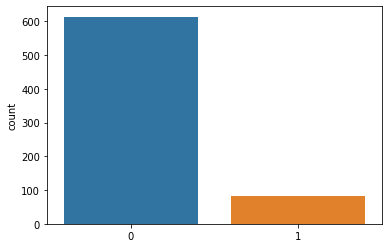

In [ ]:
import seaborn as sns
sns.countplot(prediction)

In [ ]:
from sklearn.metrics import f1_score,accuracy_score
f1_score(testY1,prediction)

0.6399999999999999

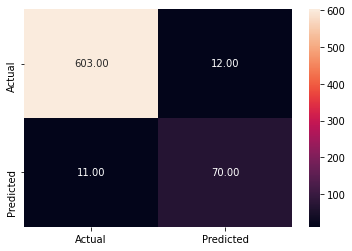

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

**Final Prediction**

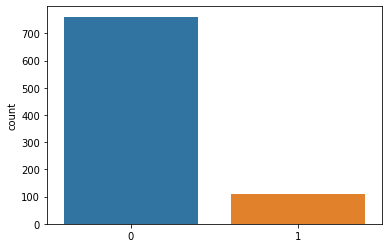

In [ ]:
sns.countplot(prediction)

#### **Dphi Scores 83.41232227488152**

**Train-Resnet101**

In [ ]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=validation_generator,
	validation_steps=len(testX1) // BS,
	epochs=30,class_weight={0:1,1:2})

Epoch 1/30
86/86 [==============================] - 21s 241ms/step - loss: 0.4379 - accuracy: 0.8713 - f1_m: 0.4326 - val_loss: 0.3117 - val_accuracy: 0.8884 - val_f1_m: 0.0000e+00
Epoch 2/30
86/86 [==============================] - 19s 222ms/step - loss: 0.3640 - accuracy: 0.8880 - f1_m: 0.5420 - val_loss: 0.3227 - val_accuracy: 0.8929 - val_f1_m: 0.1651
Epoch 3/30
86/86 [==============================] - 19s 224ms/step - loss: 0.3485 - accuracy: 0.8964 - f1_m: 0.5375 - val_loss: 0.2354 - val_accuracy: 0.8854 - val_f1_m: 0.0000e+00
Epoch 4/30
86/86 [==============================] - 19s 225ms/step - loss: 0.3319 - accuracy: 0.8964 - f1_m: 0.5574 - val_loss: 0.2371 - val_accuracy: 0.9167 - val_f1_m: 0.6270
Epoch 5/30
86/86 [==============================] - 19s 226ms/step - loss: 0.3159 - accuracy: 0.9026 - f1_m: 0.5680 - val_loss: 0.2000 - val_accuracy: 0.9137 - val_f1_m: 0.6095
Epoch 6/30
86/86 [==============================] - 20s 227ms/step - loss: 0.2834 - accuracy: 0.9091 - f1_m

**Evaluation:-Resnet101**

In [ ]:
preds = model.predict(testX1)
prediction = []
for value in preds:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

In [ ]:
from sklearn.metrics import f1_score,accuracy_score
f1_score(testY1,prediction)

0.6626506024096386

#### **Resnet50**

In [ ]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=validation_generator,
	validation_steps=len(testX1) // BS,
	epochs=30,class_weight={0:1,1:2})

Epoch 1/30
86/86 [==============================] - 13s 152ms/step - loss: 0.4327 - accuracy: 0.8713 - f1_m: 0.3829 - val_loss: 0.6327 - val_accuracy: 0.6235 - val_f1_m: 0.3675
Epoch 2/30
86/86 [==============================] - 12s 143ms/step - loss: 0.3489 - accuracy: 0.8953 - f1_m: 0.5495 - val_loss: 0.7144 - val_accuracy: 0.5045 - val_f1_m: 0.3131
Epoch 3/30
86/86 [==============================] - 12s 143ms/step - loss: 0.3734 - accuracy: 0.8902 - f1_m: 0.5208 - val_loss: 0.3036 - val_accuracy: 0.9018 - val_f1_m: 0.5693
Epoch 4/30
86/86 [==============================] - 12s 144ms/step - loss: 0.3154 - accuracy: 0.8993 - f1_m: 0.5803 - val_loss: 0.4012 - val_accuracy: 0.8155 - val_f1_m: 0.4863
Epoch 5/30
86/86 [==============================] - 12s 145ms/step - loss: 0.3194 - accuracy: 0.9019 - f1_m: 0.5793 - val_loss: 0.2486 - val_accuracy: 0.8869 - val_f1_m: 0.5726
Epoch 6/30
86/86 [==============================] - 13s 146ms/step - loss: 0.2850 - accuracy: 0.9095 - f1_m: 0.6113

In [ ]:
preds = model.predict(testX1)
prediction = []
for value in preds:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)
from sklearn.metrics import f1_score,accuracy_score
f1_score(testY1,prediction)

0.6419753086419753

**Transfer Learning experimentation end**

In [ ]:
len(trainX1) // BS

86

In [ ]:
len(testX1) // BS

21

In [ ]:
BS=32
history = model.fit(
	train_generator,
	steps_per_epoch=len(trainX1) // BS,
	validation_data=validation_generator,
	validation_steps=len(testX1) // BS,
	epochs=25,class_weight={0:1,1:2},callbacks=[callbacks,ival])

Epoch 1/25
86/86 [==============================] - ETA: 0s - loss: 3.1151e-04 - accuracy: 1.0000 - f1_m: 0.9884
Reached 95.00% accuracy, so stopping training!!
interval evaluation - epoch: 0 - score: 0.807453
86/86 [==============================] - 18s 212ms/step - loss: 3.1151e-04 - accuracy: 1.0000 - f1_m: 0.9884 - val_loss: 0.2445 - val_accuracy: 0.9539 - val_f1_m: 0.7566


#### **make predictions on test set**

In [ ]:
testX1 = testX1/255.0

In [ ]:
preds = model.predict(testX1)

In [ ]:
prediction = []
for value in preds:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

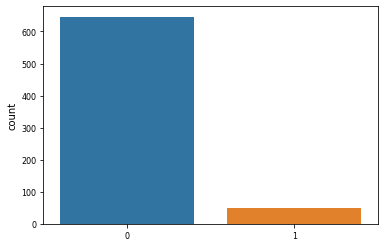

In [ ]:
import seaborn as sns
sns.countplot(prediction)

In [ ]:
from sklearn.metrics import f1_score,accuracy_score
f1_score(testY1,prediction)

0.8045977011494253

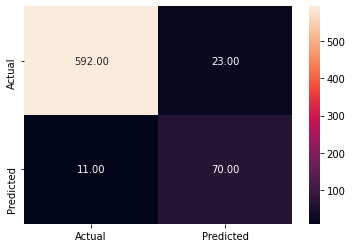

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

In [ ]:
test_pixel_data = [] # initialize an empty numpy array
image_size = 224 # image size taken is 100 here. one can take other size too
for i in range(len(test_images)):
  image_processed= cv2.imread(test_images['filepaths'][i]) # converting the image to gray scale
  image_processed  = cv2.cvtColor(image_processed,cv2.COLOR_BGR2RGB)
  new_img_array = cv2.resize(image_processed, (image_size, image_size)) # resizing the image array

  test_pixel_data.append(new_img_array)

#
test_pixel_data = np.array(test_pixel_data)
test_pixel_data  = test_pixel_data/255.0
print(test_pixel_data.shape)
#
print(test_pixel_data.shape)


(870, 224, 224, 3)
(870, 224, 224, 3)


In [ ]:
pred = model.predict(test_pixel_data)
prediction = []
for value in pred:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

#
res = pd.DataFrame({'filename': test_images['filename'], 'prediction': prediction}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res['prediction'].to_csv("submission_keras_vgg16_full1.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_keras_vgg16_full1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

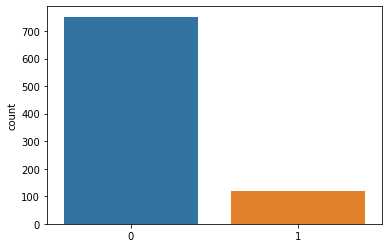

In [ ]:
sns.countplot(prediction)

#### **Classification Matrix**

In [ ]:
lb.classes_

array([0, 1])

In [ ]:
y_true=testY.argmax(axis=1)

In [ ]:
type(y_true)

numpy.ndarray

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true,predIdxs)

0.5285714285714286

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,predIdxs)

0.9051724137931034

#### **Confusion Matrix**

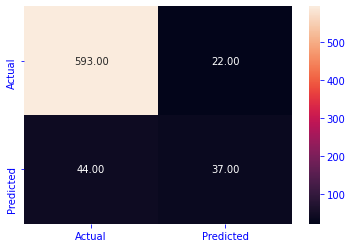

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf= confusion_matrix(y_true,predIdxs)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

**Try without image processing and check scores**

In [ ]:
history = model.fit(
	trainAug.flow(trainX1, trainY1, batch_size=BS),
	steps_per_epoch=len(trainX1) // BS,
	validation_data=(testX1, testY1),
	validation_steps=len(testX1) // BS,
	epochs=EPOCHS)

Epoch 1/25
347/347 [==============================] - 13s 37ms/step - loss: 0.2594 - accuracy: 0.8955 - val_loss: 0.2126 - val_accuracy: 0.9052
Epoch 2/25
347/347 [==============================] - 12s 35ms/step - loss: 0.2005 - accuracy: 0.9153 - val_loss: 0.2006 - val_accuracy: 0.9152
Epoch 3/25
347/347 [==============================] - 12s 35ms/step - loss: 0.1904 - accuracy: 0.9193 - val_loss: 0.1950 - val_accuracy: 0.9239
Epoch 4/25
347/347 [==============================] - 12s 35ms/step - loss: 0.1793 - accuracy: 0.9214 - val_loss: 0.1866 - val_accuracy: 0.9124
Epoch 5/25
347/347 [==============================] - 12s 35ms/step - loss: 0.1625 - accuracy: 0.9279 - val_loss: 0.2062 - val_accuracy: 0.9124
Epoch 6/25
347/347 [==============================] - 12s 35ms/step - loss: 0.1538 - accuracy: 0.9308 - val_loss: 0.1989 - val_accuracy: 0.9095
Epoch 7/25
347/347 [==============================] - 12s 35ms/step - loss: 0.1566 - accuracy: 0.9337 - val_loss: 0.1804 - val_accuracy:

In [ ]:
predIdxs = model.predict(testX1, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
y_true=testY1.argmax(axis=1)

F1 Score :0.6984126984126984
Accuracy Score : 0.9181034482758621


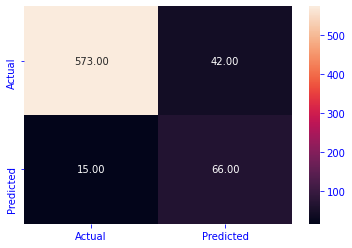

In [ ]:
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
print(f'F1 Score :{f1_score(y_true,predIdxs)}')
print(f'Accuracy Score : {accuracy_score(y_true,predIdxs)}')
cf= confusion_matrix(y_true,predIdxs)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

#### **Define Test Image preprocessing**

In [ ]:
tst = []
def testimage_processing(path,img_size):
  for i in os.listdir(path):
    image_path = path + "/" +i
    #Preprocess Image
    image_processed = cv2.imread(image_path)
    image_processed  = cv2.cvtColor(image_processed,cv2.COLOR_BGR2RGB)
    image_processed  = cv2.resize(image_processed,(img_size,img_size))
    tst.append(image_processed)
  return tst

In [ ]:
tst_image = testimage_processing("/content/content/covid_image_data/test",128)

In [ ]:
tst_image = np.array(tst_image)

In [ ]:
pred_proba = model.predict(tst_image)

In [ ]:
predictions = np.argmax(pred_proba, axis=1)

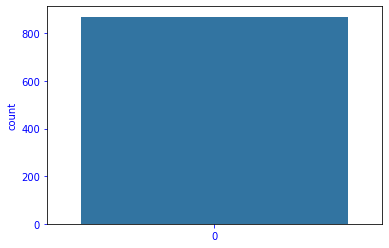

In [ ]:
sns.countplot(predictions)

## **Transfer Learning End**

In [ ]:
for i in os.listdir("/content/content/covid_image_data/train"):
  img_path = train_image_path + "/" + i
  image_original = cv2.imread(img_path)
  #Preprocess Image
  image_processed = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  image_processed = cv2.equalizeHist(image_processed)
  image_processed = cv2.medianBlur(image_processed ,3)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  image_processed  = clahe.apply(image_processed )
  image_processed  = cv2.cvtColor(image_processed,cv2.COLOR_GRAY2BGR)
  lbl = train[train['filename'] == i]['label'].tolist()[0]
  if lbl == 0:
    processed_image_path = "/content/Covid/Processed/Train/Covid_0/" + i
    cv2.imwrite(processed_image_path, image_processed)
  else:
    processed_image_path = "/content/Covid/Processed/Train/Covid_1/" + i
    cv2.imwrite(processed_image_path, image_processed)


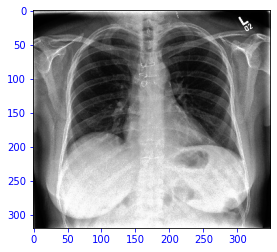

In [ ]:
plt.imshow(PIL.Image.open("/content/content/covid_image_data/train/Image_2446.jpg"))

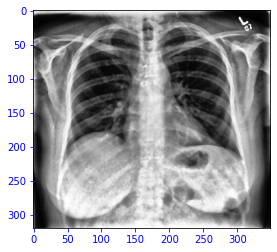

In [ ]:
plt.imshow(PIL.Image.open("/content/Image_2446.jpg"))

In [ ]:
train.label.value_counts()

0    3073
1     406
Name: label, dtype: int64

In [ ]:
len(os.listdir("/content/Covid/Processed/Train/Covid_1")),len(os.listdir("/content/Covid/Processed/Train/Covid_0"))

(406, 3073)

In [ ]:
!mkdir /content/dphi
!mkdir /content/dphi/covid19
!mkdir /content/dphi/covid19/Train
!mkdir /content/dphi/covid19/Train/covid_0
!mkdir /content/dphi/covid19/Train/covid_1

In [ ]:
!mkdir /content/dphi/covid19/Test

In [ ]:
for i in os.listdir("/content/content/covid_image_data/train"):
  if i in image_list:
    img_path =  "/content/content/covid_image_data/train/" + i
    if train[train['filename'] ==i]['label'].tolist()[0] == 0:
      shutil.copy(img_path,"/content/dphi/covid19/Train/covid_0")
    else:
      shutil.copy(img_path,"/content/dphi/covid19/Train/covid_1")

  

In [ ]:
for i in os.listdir("/content/Covid/Processed/Test"):
  shutil.move("/content/Covid/Processed/Test/"+i,"/content/dphi/covid19/Test")

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor
# Build a new pipeline for image processing.
def imageAugmentation(source,output,num_samples):
  p = Augmentor.Pipeline(
      source_directory=source,
      output_directory=output)

  # Manipulate the example card.
  p.rotate_without_crop(
    probability=.3,
    max_left_rotation=10,
    max_right_rotation=10,
    expand=True)
  p.zoom(
    probability=.3,
    min_factor=.8,
    max_factor=1.1)
  p.skew(
    probability=.3,
    magnitude=.15)
  p.random_brightness(
    probability=.5,
    min_factor=.5,
    max_factor=1.75)

  # Generate and save num_samples of  new images to the output directory.
  p.sample(num_samples=200)

In [ ]:
imageAugmentation("/content/dphi/covid19/Train/covid_1","/content/dphi/covid19/Train/covid_1",200)

Executing Pipeline:   0%|          | 0/200 [00:00<?, ? Samples/s]

Initialised with 406 image(s) found.
Output directory set to /content/dphi/covid19/Train/covid_1.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2000x2000 at 0x7F40C75A0748>: 100%|██████████| 200/200 [00:40<00:00,  4.91 Samples/s]


In [ ]:
len(os.listdir("/content/dphi/covid19/Train/covid_1"))

606

In [ ]:
def process_image(path_dir):
  dataset = []
  labels = []
  folder_images = os.listdir(path_dir)
  
  for folder in folder_images:
    print(folder)
    image_list = os.listdir(path_dir + "/"+folder+"/")
    #print(len(image_list))
    for images in image_list:
      #print(images)
      #print(path_dir+"/"+folder+"/" +images)
      image = cv2.imread(path_dir+"/"+folder+"/" +images)
      image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      image = Image.fromarray(image)
      image = image.resize((224,224))
      dataset.append(np.array(image))
      if folder == 'covid_1':
        labels.append(1)
      else:
        labels.append(0)
  return np.array(dataset),np.array(labels)


In [ ]:
X,Y= process_image("/content/dphi/covid19/Train")

covid_1
covid_0


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=42)

In [ ]:
x_train.shape,y_train.shape

((2943, 224, 224, 3), (2943,))

In [ ]:
y_train

array([0, 0, 0, 0, ..., 0, 0, 1, 1])

In [ ]:
x_train = x_train.astype(int)
x_test = x_test.astype(int)


In [ ]:
x_train[0]

array([[[ 76,  76,  76],
        [ 21,  21,  21],
        [ 12,  12,  12],
        [ 10,  10,  10],
        ...,
        [110, 110, 110],
        [121, 121, 121],
        [110, 110, 110],
        [111, 111, 111]],

       [[ 23,  23,  23],
        [ 11,  11,  11],
        [  8,   8,   8],
        [  8,   8,   8],
        ...,
        [133, 133, 133],
        [134, 134, 134],
        [134, 134, 134],
        [129, 129, 129]],

       [[ 17,  17,  17],
        [ 10,  10,  10],
        [  6,   6,   6],
        [  5,   5,   5],
        ...,
        [ 60,  60,  60],
        [ 67,  67,  67],
        [ 77,  77,  77],
        [ 88,  88,  88]],

       [[ 15,  15,  15],
        [  8,   8,   8],
        [  8,   8,   8],
        [  5,   5,   5],
        ...,
        [ 13,  13,  13],
        [ 14,  14,  14],
        [ 19,  19,  19],
        [ 28,  28,  28]],

       ...,

       [[225, 225, 225],
        [221, 221, 221],
        [235, 235, 235],
        [249, 249, 249],
        ...,
        [170, 

In [ ]:
x_train.shape,y_train.shape,type(x_train)

((2943, 224, 224, 3), (2943,), numpy.ndarray)

Text(0.5, 1.0, 'LABEL 0')

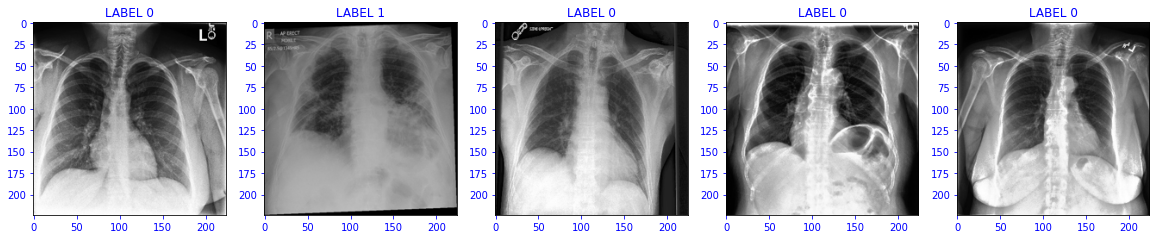

In [ ]:
plt.figure(figsize = (20, 12))
plt.subplot(1,5,1)
plt.imshow(x_train[0])
plt.title('LABEL '+str(y_train[0]))
plt.subplot(1,5,2)
plt.imshow(x_train[100])
plt.title('LABEL '+str(y_train[100]))
plt.subplot(1,5,3)
plt.imshow(x_train[10])
plt.title('LABEL '+str(y_train[10]))
plt.subplot(1,5,4)
plt.imshow(x_train[20])
plt.title('LABEL '+str(y_train[20]))
plt.subplot(1,5,5)
plt.imshow(x_train[25])
plt.title('LABEL '+str(y_train[25]))

Text(0.5, 1.0, 'LABEL 0')

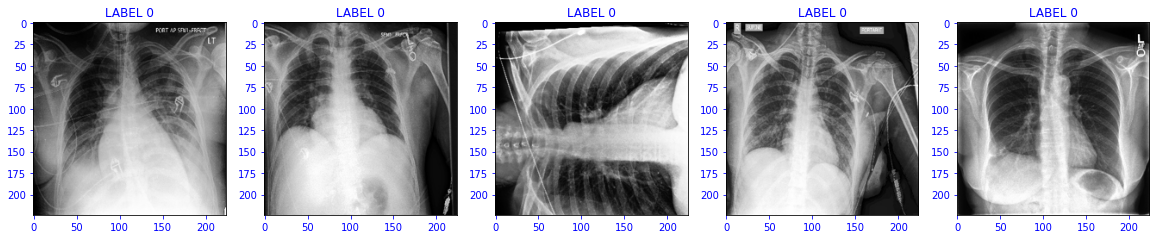

In [ ]:
plt.figure(figsize = (20, 12))
plt.subplot(1,5,1)
plt.imshow(x_test[0])
plt.title('LABEL '+str(y_test[0]))
plt.subplot(1,5,2)
plt.imshow(x_test[100])
plt.title('LABEL '+str(y_test[100]))
plt.subplot(1,5,3)
plt.imshow(x_test[10])
plt.title('LABEL '+str(y_test[10]))
plt.subplot(1,5,4)
plt.imshow(x_test[20])
plt.title('LABEL '+str(y_test[20]))
plt.subplot(1,5,5)
plt.imshow(x_test[25])
plt.title('LABEL '+str(y_test[25]))

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# create model
def classifier(IMG_SIZE):
    model = Sequential()
#     model.add(keras.Input(shape=(None, IMG_SIZE, IMG_SIZE, 3)))
#     Convolutional layer 1 with 32 filters of kernel size[5,5] 
    model.add(Conv2D(filters=32, kernel_size=(5, 5), 
                     strides=(1, 1), activation='relu', 
                     input_shape=(IMG_SIZE, IMG_SIZE, 3)))
#     Pooling layer 1 with pool size[2,2] and stride 2 
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
#     Convolutional layer 2 with 64 filters of kernel size[5,5] 
    model.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu'))
#  Pooling layer 2 with pool size[2,2] and stride 2 
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
## Newly Added
#     Convolutional layer 2 with 64 filters of kernel size[5,5] 
    model.add(Conv2D(128, (5, 5), strides=(1, 1), activation='relu'))
#  Pooling layer 2 with pool size[2,2] and stride 2 
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
## Newly Added
    model.add(Flatten())
    
#     Dense layer whose output size is fixed in the hyper parameter: 
    model.add(Dense(units=64, activation='relu'))
    
#     Dropout layer with dropout probability 0.4 
    model.add(Dropout(0.3))
    #     Dense layer whose output size is fixed in the hyper parameter: 
    model.add(Dense(units=32, activation='relu'))
    
#     Dropout layer with dropout probability 0.4 
    model.add(Dropout(0.2))
    
#     units is 2 because we have 2 classes to predict 
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Compile model
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # compile model
    model.compile(
             #optimizer=RMSprop(lr=0.001),
             optimizer=Adam(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['accuracy',f1_m])
    return model

In [ ]:
model = classifier(150)

NameError: ignored

In [ ]:
model.summary()

NameError: ignored

In [ ]:
trainY1 = np.argmax(trainY1,axis=1)

In [ ]:
testY1 = np.argmax(testY1,axis=1)

#### **Implement callback function to stop training when accuracy reaches e.g. ACCURACY_THRESHOLD = 0.95**

In [ ]:
import tensorflow as tf
ACCURACY_THRESHOLD = 0.96
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True

In [ ]:
testY1.shape

(696, 2)

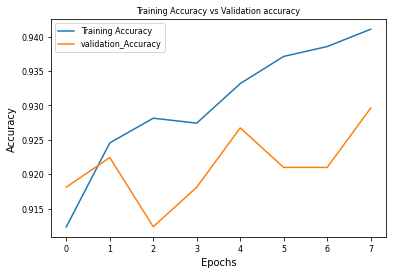

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='validation_Accuracy')
plt.title('Training Accuracy vs Validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Accuracy')
plt.show()

In [ ]:
history = model.fit(trainX1, trainY1, validation_data=(testX1,testY1), epochs=100, verbose=2,class_weight={0:1,1:2},callbacks=[ival])

NameError: ignored

Text(0, 0.5, 'Loss')

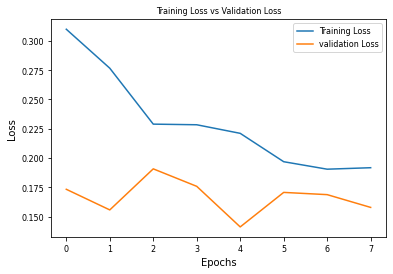

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Loss')

In [ ]:
preds = model.predict(testX1)
prediction = []
for value in preds:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

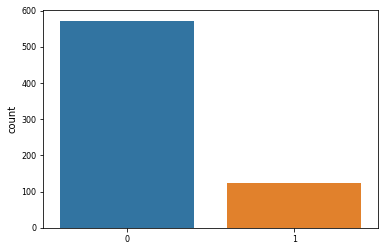

In [ ]:
import seaborn as sns
sns.countplot(prediction)

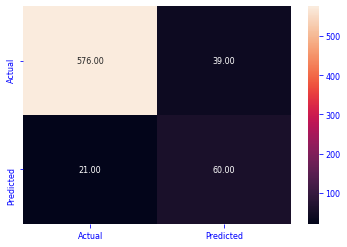

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

In [ ]:
from sklearn.metrics import f1_score
f1_score(testY1,prediction)

0.6666666666666666

#### **epochs = 10 with callback when f1_score > 75%

In [ ]:
from sklearn.metrics import f1_score
f1_score(testY1,prediction)

0.7609756097560976

**epochs = 54 due to callback**

In [ ]:
preds = model.predict(testX1)
prediction = []
for value in preds:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

In [ ]:
from sklearn.metrics import f1_score
f1_score(testY1,prediction)

0.8048780487804877

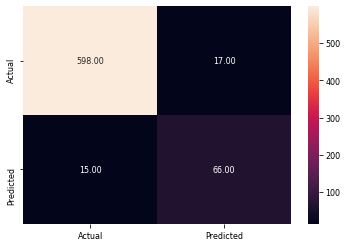

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

**Dphi Score 72.34042553191489**

#### **F1 score after incorporating callbacks**

In [ ]:
preds = model.predict(testX1)
prediction = []
for value in preds:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

In [ ]:
from sklearn.metrics import f1_score
f1_score(testY1,prediction)

0.7934782608695652

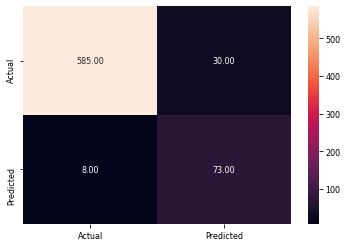

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

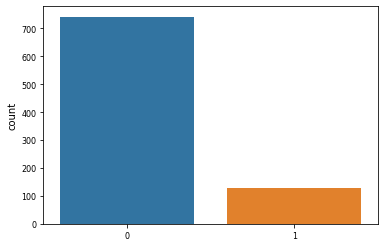

In [ ]:
sns.countplot(prediction)

**Dphi submission 78.26086956521738**

**Epochs= 15**

In [ ]:
from sklearn.metrics import f1_score
f1_score(testY1,prediction)

0.7674418604651162

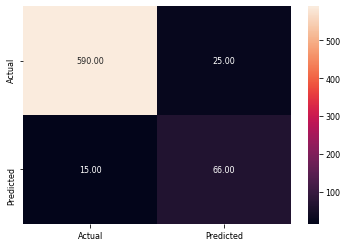

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

**After Increasing epochs to 25**

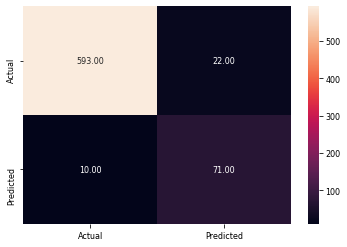

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

In [ ]:
from sklearn.metrics import f1_score
f1_score(testY1,prediction)

0.8160919540229884

**Dphi submission 80.38277511961724**

**After increasing epochs to 50**

In [ ]:
from sklearn.metrics import f1_score
f1_score(testY1,prediction)

0.7307692307692308

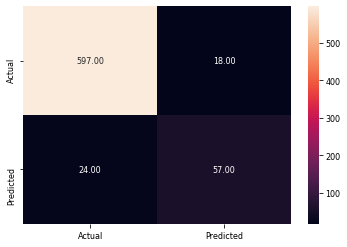

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(testY1,prediction)
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=['Actual','Predicted'],yticklabels=['Actual','Predicted'])

In [ ]:
file_paths = [[fname, '/content/content/covid_image_data/test/' + fname] for fname in test['filename']]
if len(test) == len(file_paths):
  print('Number of image names i.e. ', len(test), 'matches the number of file paths i.e. ', len(file_paths))
else:
  print('Number of image names does not match the number of filepaths')

#
test_images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_images.head()

Number of image names i.e.  870 matches the number of file paths i.e.  870


,filename,filepaths
0,Image_1.jpg,/content/content/covid_image_data/test/Image_1...
1,Image_2.jpg,/content/content/covid_image_data/test/Image_2...
2,Image_3.jpg,/content/content/covid_image_data/test/Image_3...
3,Image_4.jpg,/content/content/covid_image_data/test/Image_4...
4,Image_5.jpg,/content/content/covid_image_data/test/Image_5...


In [ ]:
test_pixel_data = [] # initialize an empty numpy array
image_size = 150 # image size taken is 100 here. one can take other size too
for i in range(len(test_images)):
  image_processed= cv2.imread(test_images['filepaths'][i]) # converting the image to gray scale
  image_processed  = cv2.cvtColor(image_processed,cv2.COLOR_BGR2RGB)
  new_img_array = cv2.resize(image_processed, (image_size, image_size)) # resizing the image array

  test_pixel_data.append(new_img_array)

#
test_pixel_data = np.array(test_pixel_data)
test_pixel_data  = test_pixel_data.astype(int)
print(test_pixel_data.shape)
#
print(test_pixel_data.shape)
pred = model.predict(test_pixel_data)
prediction = []
for value in pred:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

#
res = pd.DataFrame({'filename': test_images['filename'], 'prediction': prediction}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res['prediction'].to_csv("submission_keras_callback1.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_keras_callback1.csv')

(870, 150, 150, 3)
(870, 150, 150, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

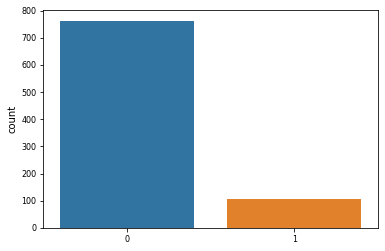

In [ ]:
sns.countplot(prediction)

**Create Another Model which inputs image size as 150 * 150 - did not work**

In [ ]:
IMG_W = 150
IMG_H = 150
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 48
BATCH_SIZE = 6

In [ ]:
def build_model(INPUT_SHAPE):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64,(3,3)))
  model.add(Activation("relu"))
  model.add(Conv2D(250,(3,3)))
  model.add(Activation("relu"))
  
  model.add(Conv2D(128,(3,3)))
  model.add(Activation("relu"))
  model.add(AvgPool2D(2,2))
  model.add(Conv2D(64,(3,3)))
  model.add(Activation("relu"))
  model.add(AvgPool2D(2,2))

  model.add(Conv2D(256,(2,2)))
  model.add(Activation("relu"))
  model.add(MaxPool2D(2,2))
    
  model.add(Flatten())
  model.add(Dense(32))
  model.add(Dropout(0.25))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy',f1_m])
  return model

In [ ]:
model = build_model(INPUT_SHAPE)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_16 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_17 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 34, 34, 64)       

In [ ]:
trainX1.shape,testX1.shape

((2783, 150, 150, 3), (696, 150, 150, 3))

In [ ]:
history = model.fit(
	trainAug.flow(trainX1, trainY1, batch_size=BS),
	steps_per_epoch=len(trainX1) // BS,
	validation_data=(testX1, testY1),
	validation_steps=len(testX1) // BS,
	epochs=EPOCHS,class_weight={0:1,1:2})

Epoch 1/48
347/347 [==============================] - 15s 44ms/step - loss: 0.5934 - accuracy: 0.8771 - f1_m: 0.0458 - val_loss: 0.3501 - val_accuracy: 0.8836 - val_f1_m: 0.0134
Epoch 2/48
347/347 [==============================] - 14s 42ms/step - loss: 0.5169 - accuracy: 0.8836 - f1_m: 0.2888 - val_loss: 0.1857 - val_accuracy: 0.8994 - val_f1_m: 0.3459
Epoch 3/48
347/347 [==============================] - 14s 42ms/step - loss: 0.6115 - accuracy: 0.8941 - f1_m: 0.3617 - val_loss: 0.1931 - val_accuracy: 0.8980 - val_f1_m: 0.3326
Epoch 4/48
347/347 [==============================] - 14s 42ms/step - loss: 0.5169 - accuracy: 0.8966 - f1_m: 0.3752 - val_loss: 0.1843 - val_accuracy: 0.9095 - val_f1_m: 0.3779
Epoch 5/48
347/347 [==============================] - 14s 42ms/step - loss: 0.4469 - accuracy: 0.8897 - f1_m: 0.3684 - val_loss: 0.1951 - val_accuracy: 0.9009 - val_f1_m: 0.4391
Epoch 6/48
347/347 [==============================] - 14s 42ms/step - loss: 0.9998 - accuracy: 0.8886 - f1_m: 

**Keras Tuner**

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 3.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78937 sha256=517b2cbb50d4b32016b9e382d4fd1c78c86390bba43327618bd12f49df9c35a5
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=bd6bfadab4042f33f7e47a4b5ab93eda5fbeabd272af38677d207dd96fe8b9d9
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from kerastuner import HyperModel, Objective
from kerastuner.tuners import BayesianOptimization
import tensorflow as tf
from kerastuner.tuners import RandomSearch
import kerastuner as kt

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)

INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 1
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(conv_base)
        model.add(Flatten())
        model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add((Dense(units=hp.Int(
                        'units',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation='relu'
                )
            )
        )
        model.add(Dense(self.num_classes, activation='sigmoid'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-6,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-5
                )
            ),
            loss='binary_crossentropy',
            metrics=['accuracy',f1_m]
        )
        return model
NUM_CLASSES = 1  
INPUT_SHAPE = (224, 224, 3)  # covid19 images input shape
hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

In [ ]:
from kerastuner.tuners import Hyperband
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import BayesianOptimization

In [ ]:
HYPERBAND_MAX_EPOCHS = 5
MAX_TRIALS = 10
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=42,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='out'
)

In [ ]:
N_EPOCH_SEARCH = 10
tuner.search(train_generator, epochs=10, validation_data=validation_generator)

Trial 10 Complete [00h 02m 54s]
val_accuracy: 0.934626430273056

Best val_accuracy So Far: 0.9583333432674408
Total elapsed time: 00h 28m 10s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
print(tuner.results_summary())


Results summary
Results in random_search/out
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_2: 0.15000000000000002
units: 448
learning_rate: 2.554965400757683e-05
Score: 0.9583333432674408
Trial summary
Hyperparameters:
dropout_2: 0.30000000000000004
units: 64
learning_rate: 4.306689058885321e-05
Score: 0.9561781585216522
Trial summary
Hyperparameters:
dropout_2: 0.25
units: 64
learning_rate: 9.775664203574933e-05
Score: 0.9482758641242981
Trial summary
Hyperparameters:
dropout_2: 0.1
units: 512
learning_rate: 0.00029414800463547564
Score: 0.9425287544727325
Trial summary
Hyperparameters:
dropout_2: 0.35000000000000003
units: 480
learning_rate: 1.9724835195225072e-05
Score: 0.934626430273056
Trial summary
Hyperparameters:
dropout_2: 0.15000000000000002
units: 256
learning_rate: 0.005151886225891427
Score: 0.9324712753295898
Trial summary
Hyperparameters:
dropout_2: 0.05
units: 64
learning_rate: 0.0009261380821587761
Score: 

Trial summary
Hyperparameters:

dropout_2: 0.15000000000000002

units: 448

learning_rate: 2.554965400757683e-05

Score: 0.9583333432674408

In [ ]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
print(best_model)


In [ ]:
test_pixel_data = [] # initialize an empty numpy array
image_size = 224 # image size taken is 100 here. one can take other size too
for i in range(len(test_images)):
  image_processed= cv2.imread(test_images['filepaths'][i]) # converting the image to gray scale
  image_processed  = cv2.cvtColor(image_processed,cv2.COLOR_BGR2RGB)
  new_img_array = cv2.resize(image_processed, (image_size, image_size)) # resizing the image array

  test_pixel_data.append(new_img_array)

#
test_pixel_data = np.array(test_pixel_data)
test_pixel_data  = test_pixel_data/255.0
print(test_pixel_data.shape)
#
print(test_pixel_data.shape)
pred = model.predict(test_pixel_data)
prediction = []
for value in pred:
  if value < 0.5:
     prediction.append(0)
  else:
    prediction.append(1)

#
res = pd.DataFrame({'filename': test_images['filename'], 'prediction': prediction}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res['prediction'].to_csv("submission_keras_decay1.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission_keras_decay1.csv')

(870, 224, 224, 3)
(870, 224, 224, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

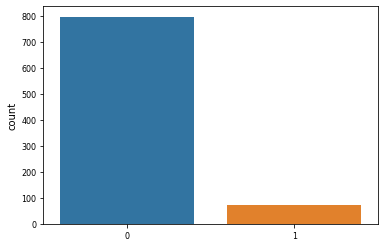

In [ ]:
sns.countplot(prediction)